# TensorFlow・Kerasのトレーニング♨

## CNN - 初歩的なCNN 編

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インポート](#インポート)
  - [共通関数](#共通関数)
- [CNNアルゴリズム・モデル](#RNNアルゴリズム・モデル)
  - [MINSTデータ](#MINSTデータ)
  - [MINST-DNN](#MINST-DNN)
  - [MINST-CNN](#MINST-CNN)
  - [CIFAR-10](#CIFAR-10)

## 参考
開発基盤部会 Wiki
- データマイニング（DM）- Python - DL  
https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20Python%20-%20DL

## [環境準備](TensorFlowAndKeras0.ipynb)

### インポート

In [ ]:
import io
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
print(tf.__version__)

import keras
print(keras.__version__)
# モデル定義
from keras.models import Model, Sequential, model_from_json, load_model
from keras.layers import Dense, Input, Activation, Flatten, Dropout, LSTM
from keras.layers import Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.optimizers import SGD, Adam
# その他
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### 共通関数

#### 画像確認

##### 画像とラベルの確認

In [2]:
def show_image_info(x, y, label, index):
    print("label: ", label[y[index]])
    print("Image: ")
    plt.imshow(x[index].astype(np.uint8))
    plt.show()

##### ランダムな画像一覧

In [3]:
def show_image_list(x, y, numOfCls=10, numOfImgInCls=10):
    pos = 1
    plt.figure(figsize=(numOfCls, numOfImgInCls))

    # クラス毎に以下の処理を繰り返す。
    for targetClass in range(numOfCls):
        targetIdx = []
        
        # 当該クラスの画像のインデックスリストを取得
        for i in range(len(y)):
            if y[i] == targetClass:
                targetIdx.append(i)
        
        # 当該クラスのインデックスリストからランダムに選んだ最初のn個の画像を描画
        np.random.shuffle(targetIdx)
        for idx in targetIdx[:numOfImgInCls]:
            plt.subplot(numOfCls, numOfImgInCls, pos)
            plt.imshow(x[idx])
            plt.axis('off')
            pos += 1

plt.show()

##### 誤った推論の画像を表示する関数

In [4]:
def show_incorrect_image_list(x, y, y_pred, label, numOfImg=10):
    index = (y != y_pred)
    for i, val in enumerate(index):
        if val == True:
            print('predict: ', label[y_pred[i]])
            print('answer : ', label[y[i]])
            show_image_info(x, y, label, i)
            numOfImg -= 1
            if numOfImg <= 0:
                break

#### [分類問題関連](ScikitLearnTraining5.ipynb)

##### 分類問題のメトリック表示関数

In [5]:
def print_metrics(label, pred):
    print('accuracy: %.3f' % metrics.accuracy_score(label, pred)) # 正答率
    
    print('\nmicro') # ミクロ平均
    print('recall: %.3f' % metrics.recall_score(label, pred, average='micro')) # 再現率
    print('precision: %.3f' % metrics.precision_score(label, pred, average='micro')) # 適合率
    print('f1_score: %.3f' % metrics.f1_score(label, pred, average='micro')) # f値
    
    print('\nmacro') # マクロ平均
    print('recall: %.3f' % metrics.recall_score(label, pred, average='macro')) # 再現率
    print('precision: %.3f' % metrics.precision_score(label, pred, average='macro')) # 適合率
    print('f1_score: %.3f' % metrics.f1_score(label, pred, average='macro')) # f値

##### 混同行列のグラフ化関数

In [6]:
def plot_cm(confmat, label):
    numOfCls = len(label)
    fig, ax = plt.subplots(figsize=(numOfCls, numOfCls))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
            
    # 軸目盛を打つ場所を決める
    ax.set_xticks(np.arange(len(label)))
    ax.set_yticks(np.arange(len(label)))
    # 軸目盛を設定
    ax.set_xticklabels(label)
    ax.set_yticklabels(label)
    #plt.xticks(np.array(label)) # x軸の目盛りを指定
    #plt.yticks(np.array(label)) # y軸の目盛りを指定
    
    plt.xlabel('y_pred label')
    plt.ylabel('y label')
    plt.show()

#### 学習履歴表示関数

##### 損失

In [7]:
def plot_history_loss(hist):
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

##### 正解率

In [8]:
def plot_history_acc(hist):
    plt.plot(hist.history['accuracy'],label="accuracy for training")
    plt.plot(hist.history['val_accuracy'],label="accuracy for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.show()

## CNNアルゴリズム・モデル

### MINSTデータ

#### 生成

In [9]:
from keras.datasets import mnist
(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data()
print(x_train_org.shape, x_test_org.shape)
print(y_train_org.shape, y_test_org.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


#### 加工
一旦、結合します。

In [10]:
x_org = np.vstack([x_train_org, x_test_org])
y_org = np.concatenate([y_train_org, y_test_org])
print(x_org.shape, y_org.shape)

(70000, 28, 28) (70000,)


#### 理解

label:  3
Image: 


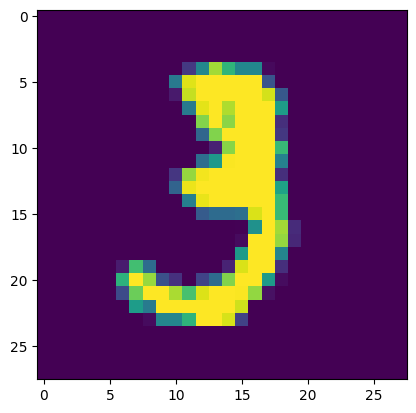

In [11]:
show_image_info(x_org, y_org, [0,1,2,3,4,5,6,7,8,9], 10)

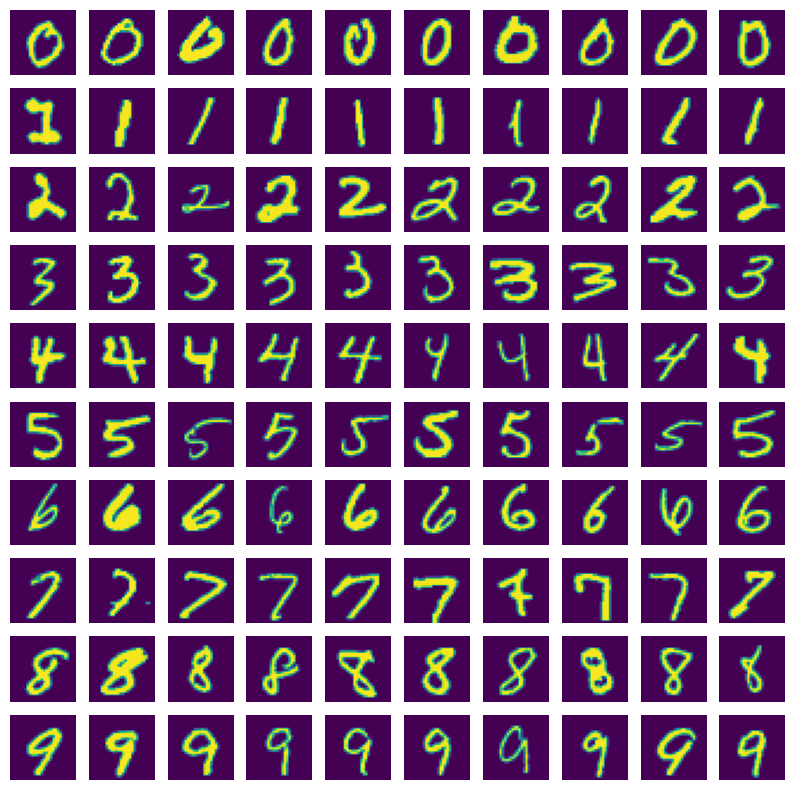

In [12]:
show_image_list(x_org, y_org, 10, 10)

#### 準備

##### XのKeras入力用型変換

In [13]:
x_std = x_org.astype('f')

##### Xの画素を0.0-1.0の範囲に正規化

In [14]:
x_std /= 255

##### 正解ラベルのOne-Hotエンコーディング
Keras（≒ 深層学習）では正解ラベルはOne-Hotベクトル化が必要。

In [15]:
# エンコーディング
yy = to_categorical(y_org, num_classes=10).astype('i') 
# デコーディング
print((yy.argmax(axis=1) == y_org).all())

True


##### 学習・テストデータの分割

In [16]:
x_train = x_std[:60000]
x_test = x_std[60000:]
y_train = yy[:60000]
y_test = yy[60000:]
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 10) (10000, 10)


### MINST-DNN

#### モデリング

##### DNNの定義
これは、CNNではなくDNN
- 入力層  
入力ベクトルの要素数だけ。
- 隠れ層が
  - 3つ
  - 900, 1000, 500ノード
  - 活性化関数はrelu
- 出力層  
多クラス分類なので
  - ノードは分類の数だけ
  - 活性化関数はsoftmax

In [ ]:
# モデルのインスタンスを作成
model = Sequential()

# addメソッドで層を追加していく。

# Flatten：入力の変換層、入力サイズを指定
model.add(Flatten(input_shape=(28, 28)))

# 入力層
# Dense：全結合（線形結合）層、出力サイズを指定
model.add(Dense(900))
# Activation: 活性化関数を定義（ReLU
model.add(Activation('relu'))

# 多層化：繰り返し
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dense(500))
model.add(Activation('relu'))

# 出力層：
# Dense：全結合（線形結合）層、出力サイズを指定
model.add(Dense(10)) # 0-9の分類なので
# Activation: 活性化関数を定義（softmax
model.add(Activation('softmax'))

##### コンパイル
- 多値分類の損失関数は交差エントロピー（categorical_crossentropy）
- [optimizer=SGD](TensorFlowAndKeras0.ipynb)を指定する。
- metricsは正解率（accuracy）

In [18]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(),
    metrics=['accuracy'])

##### 確認

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 900)            │       706,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │       901,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,113,010 (8.06 MB)

 Trainable params: 2,113,010 (8.06 MB)

 Non-trainable params: 0 (0.00 B)

#### 実行

##### 学習
DNNのMINSTを並のPCで実行すると5分位かかる。

```Python
batch_size = 100
n_epoch = 20
# Keras Model の fit() は History オブジェクトを返す
hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 batch_size=batch_size,
                 epochs=n_epoch,
                 verbose=1)
```

###### モデルの保存
結構時間がかかるのでモデルを保存しておく。

```Python
model.save('../work/minst-dnn.h5')
```

###### モデルの復元

In [20]:
model = load_model('../work/minst-dnn.h5')

##### 推論

###### 個別

label:  3
Image: 


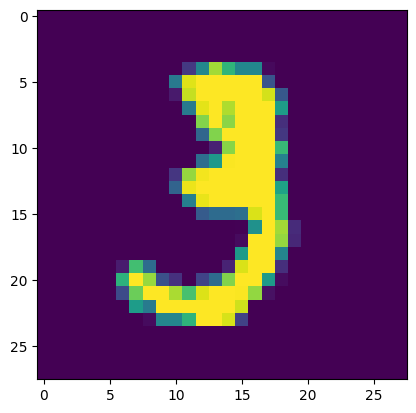

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
predict:  3
answer :  3
正解


In [21]:
index = 10
show_image_info(x_org, y_org, [0,1,2,3,4,5,6,7,8,9], index)

predict = model.predict(x_std[index].reshape(1, 28, 28)).argmax()
answer  = y_org[index]

print('predict: ', predict)
print('answer : ', answer)

if predict == answer:
    print('正解')
else:
    print('不正解')

###### 一括

In [22]:
yy_pred = model.predict(x_std)

   7/2188 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step   

2024-11-13 18:00:44.870048: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 219520000 exceeds 10% of free system memory.


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step


#### 評価

##### 実測・予測を表示

In [23]:
y_pred = np.array(yy_pred.argmax(axis=1), dtype=np.int64)
ret = (y_org == y_pred)
print(str((len(np.where(ret==True)[0]) / ret.size) * 100) +'%')

97.71428571428571%


##### [スコアを表示](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#uf759972)

In [24]:
print(model.metrics_names)

['loss', 'compile_metrics']


In [25]:
score = model.evaluate(x_std, yy)
print('loss:', score[0])
print('accuracy:', score[1])

2024-11-13 18:00:55.167516: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 219520000 exceeds 10% of free system memory.


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9783 - loss: 0.0778
loss: 0.08117364346981049
accuracy: 0.977142870426178


In [26]:
train_score = model.evaluate(x_train, y_train)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9785 - loss: 0.0772
Train loss: 0.07834061980247498
Train accuracy: 0.9782666563987732


In [27]:
test_score = model.evaluate(x_test, y_test)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9651 - loss: 0.1158
Test loss: 0.09817196428775787
Test accuracy: 0.9703999757766724


##### 混同行列
間違い易い組合せが解る。

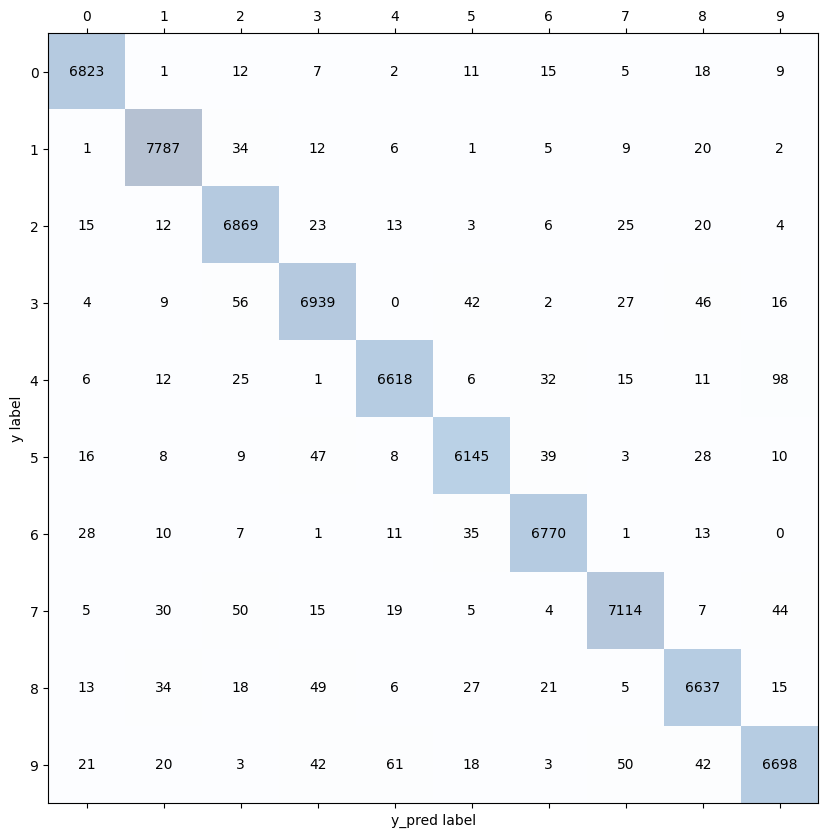

In [28]:
cm_minst = confusion_matrix(y_org, y_pred)
plot_cm(cm_minst, [0,1,2,3,4,5,6,7,8,9])

###### 混同行列のメトリクス

In [29]:
print_metrics(y_org, y_pred)

accuracy: 0.977

micro
recall: 0.977
precision: 0.977
f1_score: 0.977

macro
recall: 0.977
precision: 0.977
f1_score: 0.977


###### 間違った組み合わせの表示

predict:  0
answer :  9
label:  9
Image: 


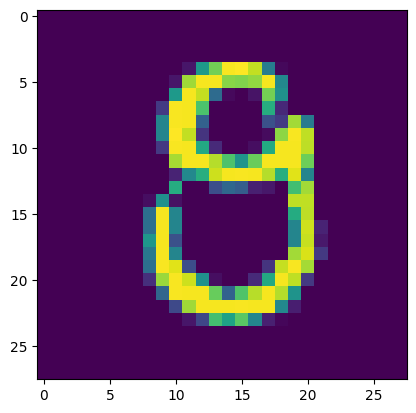

predict:  1
answer :  5
label:  5
Image: 


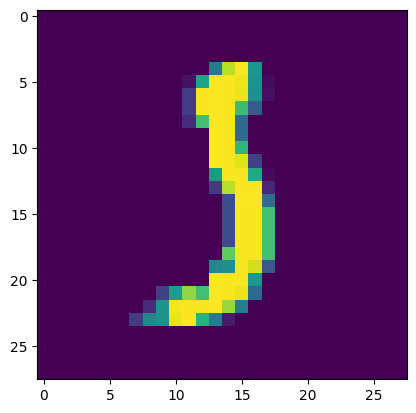

predict:  3
answer :  1
label:  1
Image: 


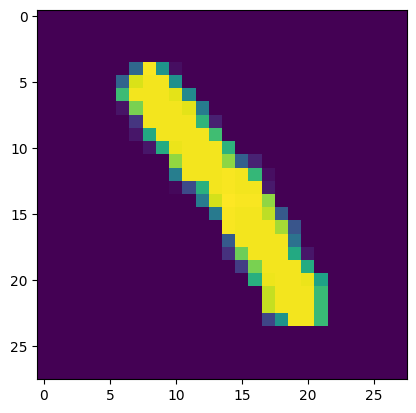

predict:  7
answer :  9
label:  9
Image: 


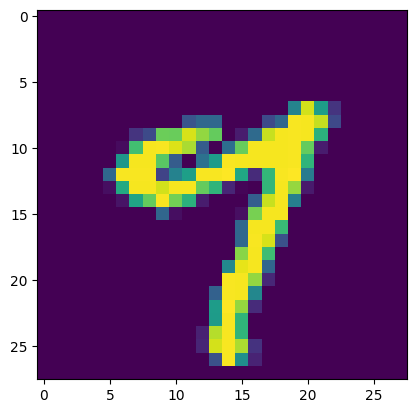

predict:  1
answer :  2
label:  2
Image: 


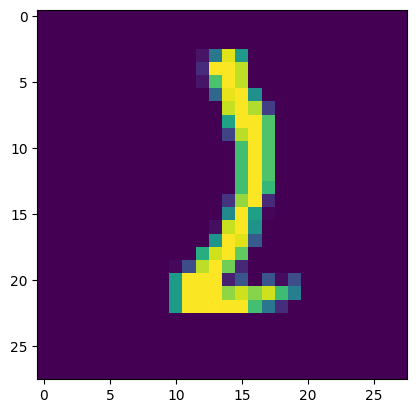

In [30]:
show_incorrect_image_list(x_org, y_org, y_pred, [0,1,2,3,4,5,6,7,8,9], 5)

##### 学習履歴を表示

In [31]:
#plot_history_loss(hist)

In [32]:
#plot_history_acc(hist)

### MINST-CNN

#### モデリング

##### CNNの定義

In [33]:
model = Sequential()

# 畳み込み１
model.add(Conv2D(32, # フィルター数
                 input_shape=(28, 28, 1),
                 kernel_size=(3, 3),
                 activation='relu'))
# 畳み込み２
model.add(Conv2D(64, # フィルター数
                 kernel_size=(3, 3),
                 activation='relu'))
# プーリング１
model.add(MaxPool2D(pool_size=(2, 2)))

# 画像からベクトル（畳み込み＆プーリング → 全結合の所に挿入
model.add(Flatten())

# Dropoutの追加位置
# 無効化比率0.25のDropout
model.add(Dropout(0.25))

# 全結合層１
model.add(Dense(128, activation='relu'))

# Dropoutの追加位置
# 無効化比率0.5のDropout
model.add(Dropout(0.5))

# 最終層は無効化しない

# 全結合層２
model.add(Dense(10, activation='softmax'))

##### コンパイル
- 多値分類の損失関数は交差エントロピー（categorical_crossentropy）
- [optimizer=SGD](TensorFlowAndKeras0.ipynb)を指定する。
- metricsは正解率（accuracy）

In [34]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

##### 確認

In [35]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

#### 実行

##### 学習
CNNのMINSTを並のPCで実行すると20分位かかる（のでload_modelする。

```python
batch_size = 100
n_epoch = 20
# Keras Model の fit() は History オブジェクトを返す
hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 batch_size=batch_size,
                 epochs=n_epoch,
                 verbose=1)
```

###### モデルの保存
結構時間がかかるのでモデルを保存しておく。

```python
model.save('../work/minst-cnn.h5')
```

###### モデルの復元

In [36]:
model = load_model('../work/minst-cnn.h5')

##### 推論

###### 個別

label:  3
Image: 


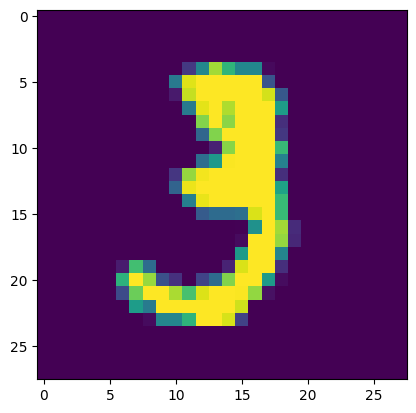

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
predict:  3
answer :  3
正解


In [37]:
index = 10
show_image_info(x_org, y_org, [0,1,2,3,4,5,6,7,8,9], index)

predict = model.predict(x_std[index].reshape(1, 28, 28)).argmax()
answer  = y_org[index]

print('predict: ', predict)
print('answer : ', answer)

if predict == answer:
    print('正解')
else:
    print('不正解')

###### 一括

In [38]:
yy_pred = model.predict(x_std)

  14/2188 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step 

2024-11-13 18:01:19.612891: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 219520000 exceeds 10% of free system memory.


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step


#### 評価

##### 実測・予測を表示

In [39]:
y_pred = np.array(yy_pred.argmax(axis=1), dtype=np.int64)
ret = (y_org == y_pred)
print(str((len(np.where(ret==True)[0]) / ret.size) * 100) +'%')

99.83428571428571%


##### [スコアを表示](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#uf759972)
以下のコードが動かなくなっていたのでマークダウン・アウト

```python
score = model.evaluate(x_std, yy)
print('loss:', score[0])
print('accuracy:', score[1])
```

```python
train_score = model.evaluate(x_train, y_train)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
```

```python
test_score = model.evaluate(x_test, y_test)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])
```

##### 混同行列
間違い易い組合せが解る。

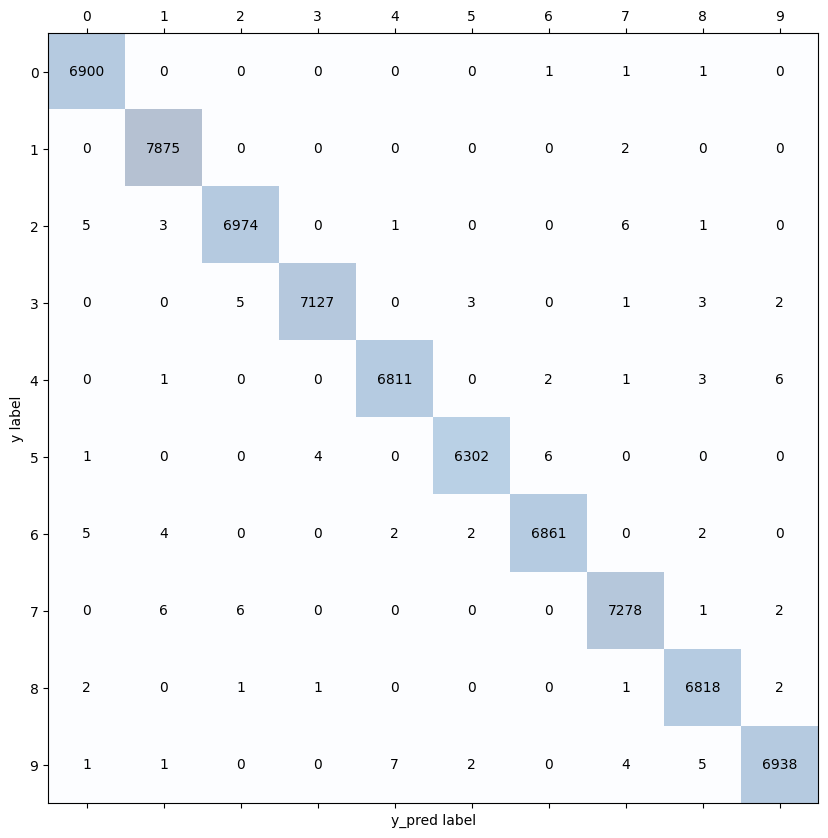

In [40]:
cm_minst = confusion_matrix(y_org, y_pred)
plot_cm(cm_minst, [0,1,2,3,4,5,6,7,8,9])

###### 混同行列のメトリクス

In [41]:
print_metrics(y_org, y_pred)

accuracy: 0.998

micro
recall: 0.998
precision: 0.998
f1_score: 0.998

macro
recall: 0.998
precision: 0.998
f1_score: 0.998


###### 間違った組み合わせの表示

predict:  9
answer :  7
label:  7
Image: 


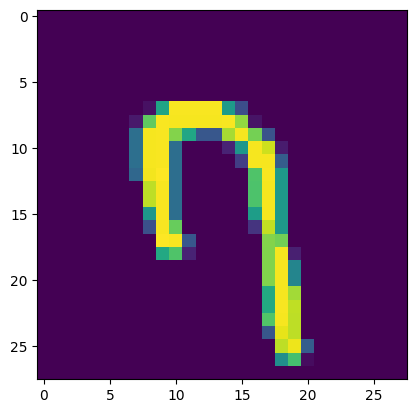

predict:  1
answer :  2
label:  2
Image: 


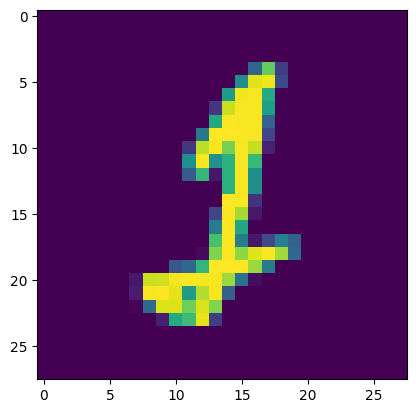

predict:  0
answer :  2
label:  2
Image: 


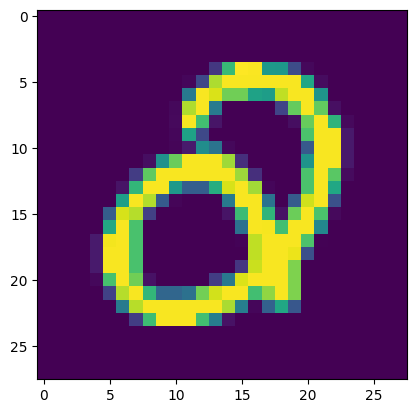

predict:  5
answer :  3
label:  3
Image: 


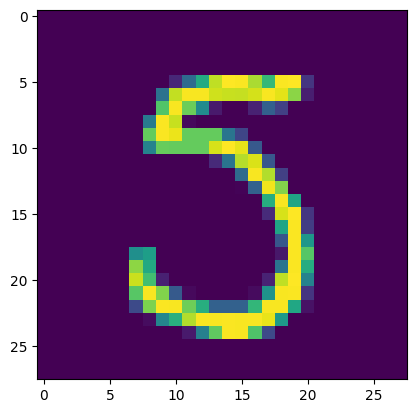

predict:  6
answer :  5
label:  5
Image: 


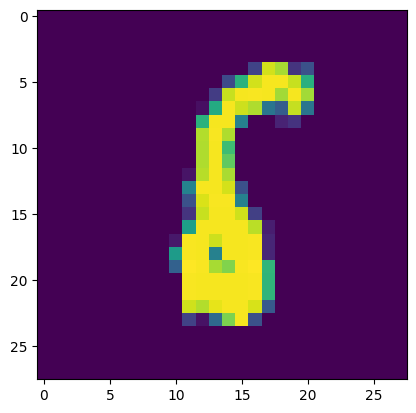

In [42]:
show_incorrect_image_list(x_org, y_org, y_pred, [0,1,2,3,4,5,6,7,8,9], 5)

##### 学習履歴を表示

In [43]:
#plot_history_loss(hist)

In [44]:
#plot_history_acc(hist)

### CIFAR-10
商品の自動タグ付け

#### データ

##### 生成

In [45]:
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context
from keras.datasets import cifar10
(x_train_org, y_train_org), (x_test_org, y_test_org) = cifar10.load_data()
print(x_train_org.shape, x_test_org.shape)
print(y_train_org.shape, y_test_org.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000, 1)


##### 加工

###### 一旦、結合します。

In [46]:
x_org = np.vstack([x_train_org, x_test_org])
y_org = np.concatenate([y_train_org, y_test_org])
print(x_org.shape, y_org.shape)

(60000, 32, 32, 3) (60000, 1)


##### 理解

label:  4
Image: 


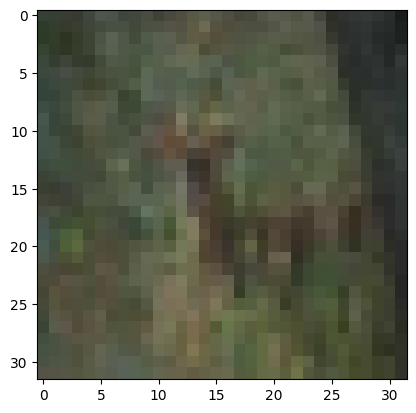

In [47]:
show_image_info(x_org, y_org.flatten(), [0,1,2,3,4,5,6,7,8,9], 10)

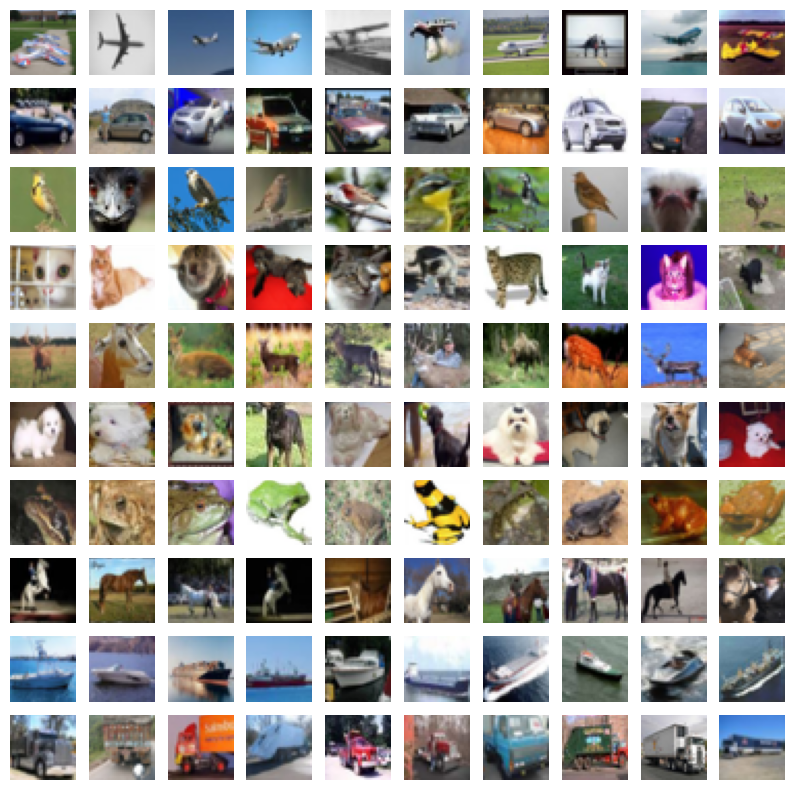

In [48]:
show_image_list(x_org, y_org.flatten(), 10, 10)

##### 準備

###### 要素の並び順を入れ替える
（Opencv, Kerasの仕様の関係上

In [49]:
# サンプル数, height, width, channelへ変更
#x_org = x_org.transpose([0, 2, 3, 1])

###### XのKeras入力用型変換

In [50]:
x_std = x_org.astype('f')

###### Xの画素を0.0-1.0の範囲に正規化

In [51]:
x_std /= 255

###### 正解ラベルのOne-Hotエンコーディング
Kerasでは正解ラベルはOne-Hotベクトル化が必要。

In [52]:
# エンコーディング
yy = to_categorical(y_org.flatten(), num_classes=10).astype('i') 
# デコーディング
print((yy.argmax(axis=1) == y_org.flatten()).all())

True


###### 学習・テストデータの分割

In [53]:
x_train = x_std[:50000]
x_test = x_std[50000:]
y_train = yy[:50000]
y_test = yy[50000:]
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 10) (10000, 10)


#### モデリング

##### CNNの定義
- 入力層  
入力ベクトルの要素数だけ。
- 隠れ層が
  - 畳み込み層とプーリング層1-3
  - 全結合層1-2
- 出力層  
多クラス分類なので
  - ノードは分類の数だけ
  - 活性化関数はsoftmax

In [54]:
model = Sequential()

# 畳み込み層とプーリング層１ 
## 畳み込み層
model.add(Conv2D(
    input_shape=(32, 32, 3), # 入力層のサイズを決める
    filters=64,              # フィルタ数
    kernel_size=(4, 4),      # カーネル・サイズ
    strides=(1, 1),          # ストライド
    padding='same'))         # パディング
## プーリング層
model.add(MaxPool2D(pool_size=(2, 2))) 
model.add(Activation('relu'))

# 畳み込み層とプーリング層２
## 畳み込み層
model.add(Conv2D(
    filters=128,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same'))
## プーリング層
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Activation('relu'))

# 畳み込み層とプーリング層３
## 畳み込み層
model.add(Conv2D(
    filters=128,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same'))
## プーリング層
model.add(MaxPool2D(pool_size=(2, 2))) 
model.add(Activation('relu'))

# 画像からベクトル（畳み込み＆プーリング → 全結合の所に挿入
model.add(Flatten())

# 全結合層１
model.add(Dense(512))
model.add(Activation('relu'))

# Dropoutの追加位置
## 無効化比率0.5のDropout
#model.add(Dropout(rate=0.5))
## 最終層は無効化しない

# 全結合層２
model.add(Dense(10))
model.add(Activation('softmax'))

##### コンパイル
- 多値分類の損失関数は交差エントロピー（categorical_crossentropy）
- [optimizer=SGD](TensorFlowAndKeras0.ipynb)を指定する。
- metricsは正解率（accuracy）

In [55]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(0.01), # 学習率：0.01
              metrics=['accuracy'])

##### 確認

In [56]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,450,826 (5.53 MB)

 Trainable params: 1,450,826 (5.53 MB)

 Non-trainable params: 0 (0.00 B)

#### 実行

##### 学習
並のPCで実行すると数時間かかる（GPUが必要

```python
batch_size = 500
n_epoch = 30
hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 batch_size=batch_size,
                 epochs=n_epoch,
                 verbose=1)
```

###### モデルの保存
結構時間がかかるのでモデルを保存しておく。

In [57]:
#model.save('../work/cifar10-cnn.h5')

###### モデルの復元

In [58]:
model = load_model('../work/cifar10-cnn.h5')

##### 推論

###### 個別

label:  車
Image: 


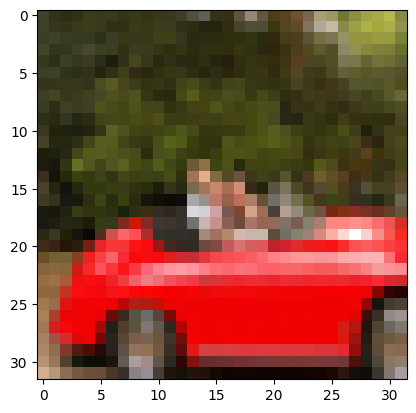

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
predict:  1
answer :  [1]
正解


In [59]:
index = 99
show_image_info(x_org, y_org.flatten(), ['飛','車','鳥','猫','鹿','犬','蛙','馬','船','貨'], index)

predict = model.predict(x_std[index].reshape(1, 32, 32, 3)).argmax()
answer  = y_org[index]

print('predict: ', predict)
print('answer : ', answer)

if predict == answer:
    print('正解')
else:
    print('不正解')

###### 一括

In [60]:
# The kernel appears to have died. It will restart automatically. と落ちるので100問に減らした。
yy_pred = model.predict(x_std[:100])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


#### 評価

##### 実測・予測を表示
- 10選で50％なら、一応学習できているがまだまだ正解率が低過ぎる。
- 参考：https://qiita.com/T-STAR/items/de933c67b52a47f9efef

In [61]:
y_pred = np.array(yy_pred.argmax(axis=-1), dtype=np.uint8)
ret = (y_org[:100].flatten() == y_pred)
print(str((len(np.where(ret==True)[0]) / ret.size) * 100) +'%')

54.0%


##### [スコアを表示](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#uf759972)
以下のコードが動かなくなっていたのでマークダウン・アウト

```python
score = model.evaluate(x_std, yy)
print('loss:', score[0])
print('accuracy:', score[1])
```

```python
train_score = model.evaluate(x_train, y_train)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
```

```python
test_score = model.evaluate(x_test, y_test)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])
```

##### 混同行列
間違い易い組合せが解る（犬・猫とか車・船とか）。

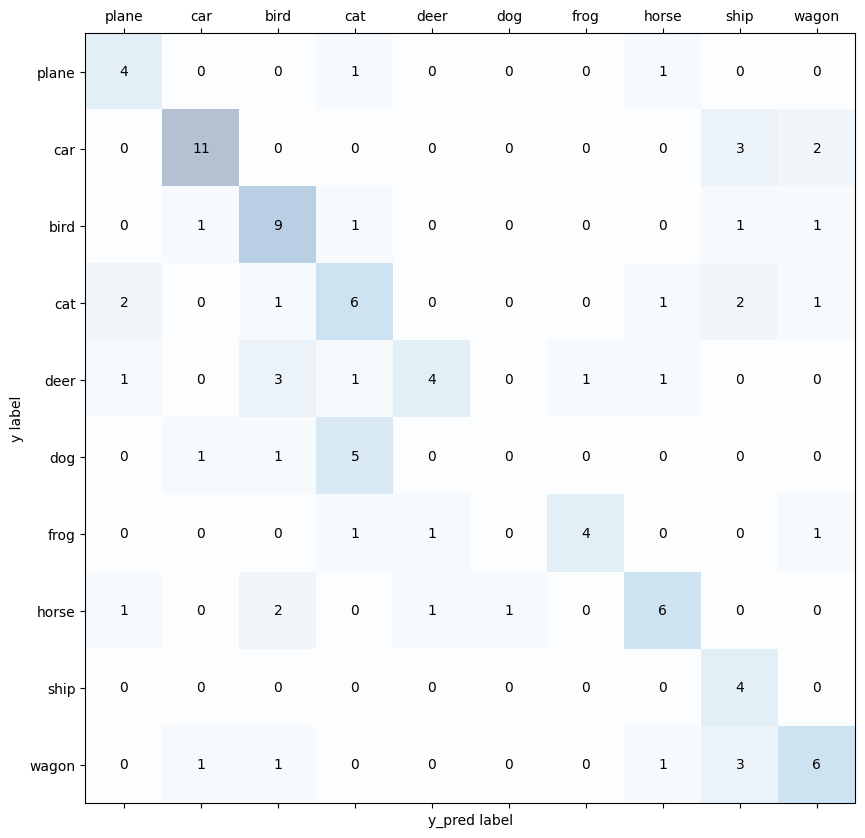

In [62]:
cm_cifar10 = confusion_matrix(y_org[:100], y_pred[:100])
plot_cm(cm_cifar10, 
       ['plane','car','bird','cat','deer','dog','frog','horse','ship','wagon'])

###### 混同行列のメトリクス

In [63]:
print_metrics(y_org[:100], y_pred[:100])

accuracy: 0.540

micro
recall: 0.540
precision: 0.540
f1_score: 0.540

macro
recall: 0.549
precision: 0.513
f1_score: 0.503


###### 間違った組み合わせの表示

predict:  蛙
answer :  鹿
label:  鹿
Image: 


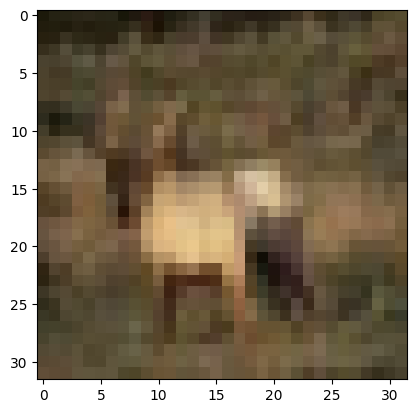

predict:  船
answer :  車
label:  車
Image: 


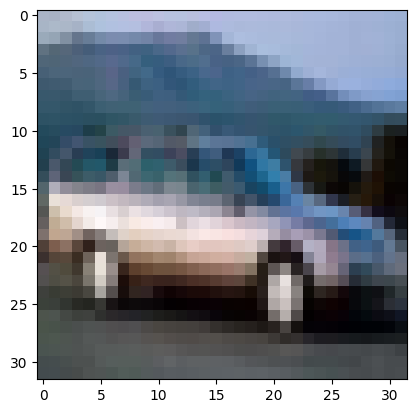

predict:  馬
answer :  猫
label:  猫
Image: 


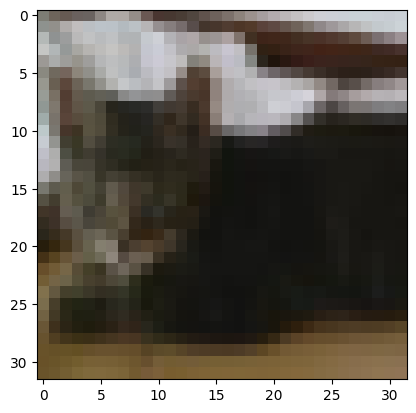

predict:  鳥
answer :  馬
label:  馬
Image: 


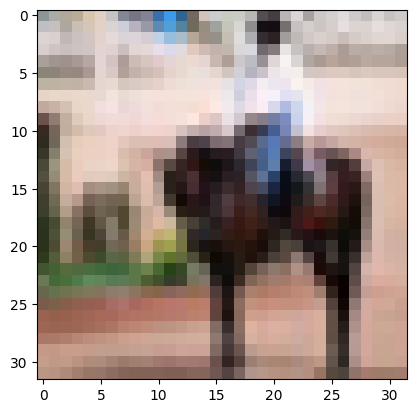

predict:  飛
answer :  馬
label:  馬
Image: 


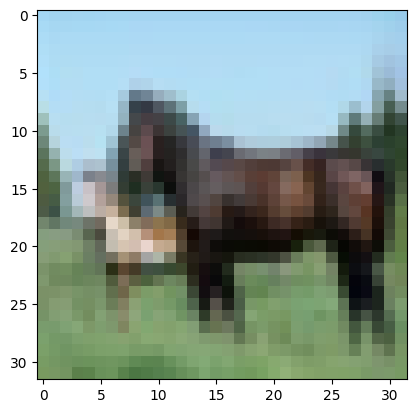

In [64]:
show_incorrect_image_list(
    x_org[:100], y_org[:100].flatten(), y_pred[:100],
    ['飛','車','鳥','猫','鹿','犬','蛙','馬','船','貨'], 5)

##### 学習履歴を表示

In [65]:
#plot_history_loss(hist)

In [66]:
#plot_history_acc(hist)